### Authors: </br>
Ruy Guzmán </br>
Fernanda de León </br>
Karla Mondragón

# LSTM

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## Dataset Overview

In [2]:
df_msft = pd.read_csv('../dataBase/ticker_MSFT.csv')
df_goog = pd.read_csv('../dataBase/ticker_GOOG.csv')
df_v = pd.read_csv('../dataBase/ticker_V.csv')

dflist = [df_msft, df_goog, df_v]

In [3]:
for df in dflist:
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", inplace=True)

In [4]:
dflist

[                  Open        High         Low       Close   Adj Close  \
 Date                                                                     
 2021-12-06  323.950012  327.450012  319.230011  326.190002  320.321655   
 2021-12-07  331.640015  335.799988  330.100006  334.920013  328.894592   
 2021-12-08  335.309998  335.500000  330.799988  334.970001  328.943665   
 2021-12-09  334.410004  336.489990  332.119995  333.100006  327.107300   
 2021-12-10  334.980011  343.000000  334.790009  342.540009  336.377502   
 ...                ...         ...         ...         ...         ...   
 2023-11-29  383.760010  384.299988  377.440002  378.850006  378.850006   
 2023-11-30  378.489990  380.089996  375.470001  378.910004  378.910004   
 2023-12-01  376.760010  378.160004  371.309998  374.510010  374.510010   
 2023-12-04  369.100006  369.519989  362.899994  369.140015  369.140015   
 2023-12-05  366.450012  371.390015  365.621002  371.372009  371.372009   
 
               Volume S

In [5]:
for i in range(len(dflist)):
    dflist[i].drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)

In [6]:
COMPANIES = ['Microsoft','Google','VISA']

In [7]:
def plotVariables(df,vars, title):
    i = 0
    for group in df:
        group[vars].plot(
            figsize=(10, 5),
            title=f"{title} - Stock: {COMPANIES[i]}",
            subplots=True,
        )
        plt.show()
        i+=1

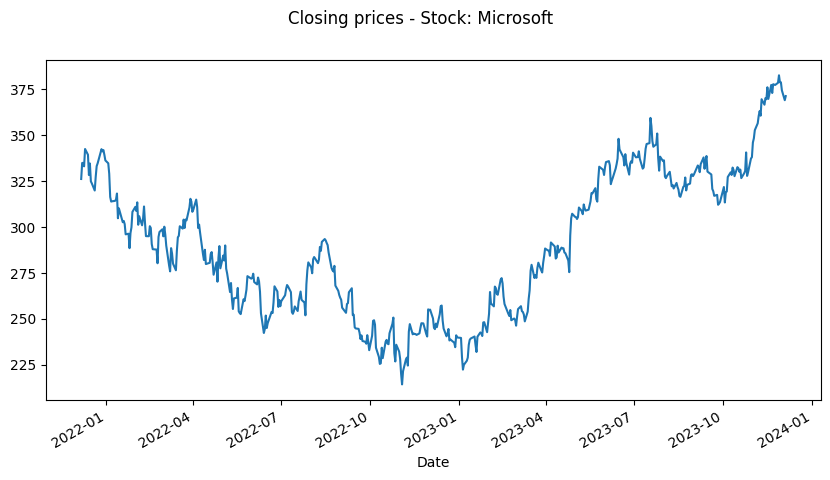

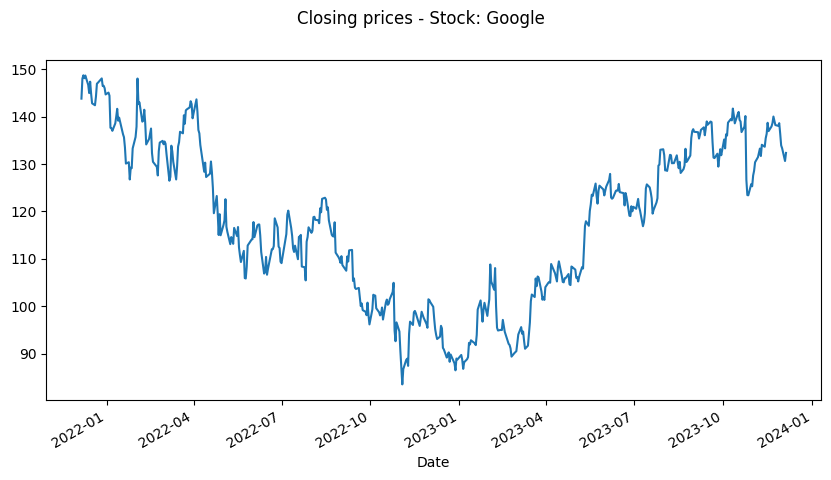

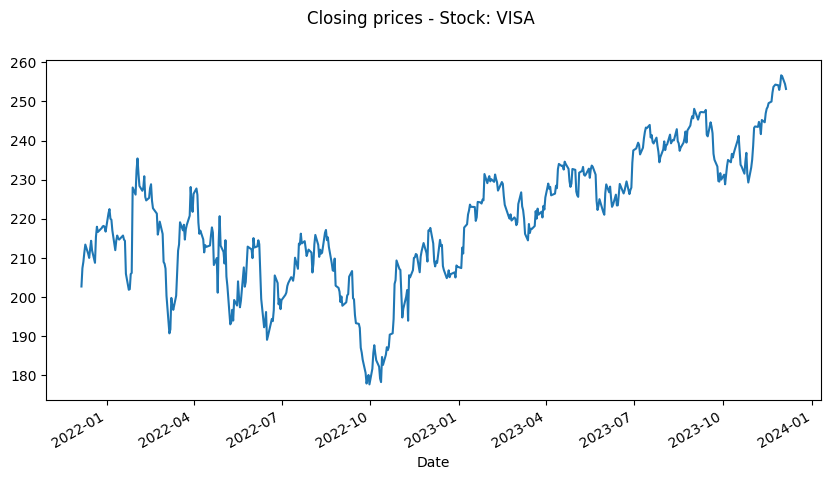

In [8]:
plotVariables(dflist,'Close', 'Closing prices')

## Data Preprocessing

In [9]:
split_date = '2023-01-01'

traininig_data_msft = df_msft.loc[df_msft.index < split_date]
traininig_data_goog = df_goog.loc[df_goog.index < split_date]
training_data_visa = df_v.loc[df_v.index < split_date]

In [10]:
# Normalize data
scaler_msft = MinMaxScaler(feature_range=(0,1))
scaled_data_msft = scaler_msft.fit_transform(traininig_data_msft['Close'].values.reshape(-1,1))

scaler_goog = MinMaxScaler(feature_range=(0,1))
scaled_data_goog = scaler_goog.fit_transform(traininig_data_goog['Close'].values.reshape(-1,1))

scaler_visa = MinMaxScaler(feature_range=(0,1))
scaled_data_v = scaler_visa.fit_transform(training_data_visa['Close'].values.reshape(-1,1))

In [11]:
# Set the number of days used for prediction
prediction_days = 26

# Initialize empty lists for training data input and output
x_train_msft, y_train_msft = [], []
x_train_goog, y_train_goog = [], []
x_train_v, y_train_v = [], []

# Iterate through the scaled data, starting from the prediction_days index
for x in range(prediction_days, len(scaled_data_msft)):
    # Append the previous 'prediction_days' values to x_train
    x_train_msft.append(scaled_data_msft[x - prediction_days:x, 0])
    x_train_goog.append(scaled_data_goog[x - prediction_days:x, 0])
    x_train_v.append(scaled_data_v[x - prediction_days:x, 0])

    # Append the current value to y_train_msft
    y_train_msft.append(scaled_data_msft[x, 0])
    y_train_goog.append(scaled_data_goog[x, 0])
    y_train_v.append(scaled_data_v[x, 0])

# Convert the x_train_msft and y_train_msft lists to numpy arrays
x_train_msft, y_train_msft = np.array(x_train_msft), np.array(y_train_msft)
x_train_goog, y_train_goog = np.array(x_train_goog), np.array(y_train_goog)
x_train_v, y_train_v = np.array(x_train_v), np.array(y_train_v)

# Reshape x_train_msft to a 3D array with the appropriate dimensions for the LSTM model
x_train_msft = np.reshape(x_train_msft, (x_train_msft.shape[0], x_train_msft.shape[1], 1))
x_train_goog = np.reshape(x_train_goog, (x_train_goog.shape[0], x_train_goog.shape[1], 1))
x_train_v = np.reshape(x_train_v, (x_train_v.shape[0], x_train_v.shape[1], 1))

In [12]:
def LSTM_model(x_train):
    # Initialize a sequential model
    model = Sequential()

    # Add the first LSTM layer with 50 units, input shape, and return sequences
    model.add(LSTM(units=75, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))
    # Add a second LSTM layer with 50 units and return sequences
    model.add(LSTM(units=75, return_sequences=True))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a third LSTM layer with 50 units
    model.add(LSTM(units=75))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))
    
    # Add a dense output layer with one unit
    model.add(Dense(units=1))

    return model

## Training

In [13]:
# Define callbacks

# Save weights only for best model
checkpointer_msft = ModelCheckpoint(
    filepath='weights_best_msft.hdf5',
    verbose=2,
    save_best_only=True
)

checkpointer_goog = ModelCheckpoint(
    filepath='weights_best_goog.hdf5',
    verbose=2,
    save_best_only=True
)

checkpointer_v = ModelCheckpoint(
    filepath='weights_best_v.hdf5',
    verbose=2,
    save_best_only=True
)

In [14]:
model_msft = LSTM_model(x_train_msft)
model_msft.compile(optimizer='adam', loss='mean_squared_error')
model_msft.fit(x_train_msft, y_train_msft, epochs=35, batch_size=32, callbacks=[checkpointer_msft])

model_goog = LSTM_model(x_train_goog)
model_goog.compile(optimizer='adam', loss='mean_squared_error')
model_goog.fit(x_train_goog, y_train_goog, epochs=25, batch_size=32, callbacks=[checkpointer_goog])

model_v = LSTM_model(x_train_v)
model_v.compile(optimizer='adam', loss='mean_squared_error')
model_v.fit(x_train_v, y_train_v, epochs=45, batch_size=32, callbacks=[checkpointer_v])



Epoch 1/35

8/8 [==============================] - 6s 30ms/step - loss: 0.0546
Epoch 2/35
8/8 [==============================] - 0s 34ms/step - loss: 0.0191
Epoch 3/35
8/8 [==============================] - 0s 32ms/step - loss: 0.0154
Epoch 4/35
8/8 [==============================] - 0s 33ms/step - loss: 0.0134
Epoch 5/35
8/8 [==============================] - 0s 31ms/step - loss: 0.0126
Epoch 6/35
8/8 [==============================] - 0s 41ms/step - loss: 0.0112
Epoch 7/35
8/8 [==============================] - 0s 41ms/step - loss: 0.0094
Epoch 8/35
8/8 [==============================] - 0s 33ms/step - loss: 0.0102
Epoch 9/35
8/8 [==============================] - 0s 42ms/step - loss: 0.0096
Epoch 10/35
8/8 [==============================] - 0s 40ms/step - loss: 0.0100
Epoch 11/35
8/8 [==============================] - 0s 39ms/step - loss: 0.0097
Epoch 12/35
8/8 [==============================] - 0s 39ms/step - loss: 0.0092
Epoch 13/35
8/8 [==============================] - 0s 37ms

## Inference

In [15]:
# Load test data for the specified company and date range
test_data_msft = df_msft.loc[df_msft.index >= split_date]
test_data_goog = df_goog.loc[df_goog.index >= split_date]
test_data_v = df_v.loc[df_v.index >= split_date]

# Extract the actual closing prices from the test data
actual_prices_msft = test_data_msft['Close'].values
actual_prices_goog = test_data_goog['Close'].values
actual_prices_v = test_data_v['Close'].values

# Concatenate the training and test data along the 'Close' column
total_dataset_msft = pd.concat((df_msft['Close'], test_data_msft['Close']), axis=0)
total_dataset_goog = pd.concat((df_goog['Close'], test_data_goog['Close']), axis=0)
total_dataset_v = pd.concat((df_v['Close'], test_data_v['Close']), axis=0)

# Extract the relevant portion of the dataset for model inputs
model_inputs_msft = total_dataset_msft[len(total_dataset_msft) - len(test_data_msft) - prediction_days:].values
model_inputs_goog = total_dataset_goog[len(total_dataset_goog) - len(test_data_goog) - prediction_days:].values
model_inputs_v = total_dataset_v[len(total_dataset_v) - len(test_data_v) - prediction_days:].values

# Reshape the model inputs to a 2D array with a single column
model_inputs_msft = model_inputs_msft.reshape(-1, 1)
model_inputs_goog = model_inputs_goog.reshape(-1, 1)
model_inputs_v = model_inputs_v.reshape(-1, 1)

# Apply the same scaling used for training data to the model inputs for Microsoft
model_inputs_msft = scaler_msft.transform(model_inputs_msft)
model_inputs_goog = scaler_goog.transform(model_inputs_goog)
model_inputs_v = scaler_visa.transform(model_inputs_v)

In [16]:
# Initialize an empty list for test data input
x_test_msft = []
x_test_goog = []
x_test_v = []

for x in range(prediction_days, len(model_inputs_msft)):
    x_test_msft.append(model_inputs_msft[x - prediction_days:x, 0])
    x_test_goog.append(model_inputs_goog[x - prediction_days:x, 0])
    x_test_v.append(model_inputs_v[x - prediction_days:x, 0])

# Convert the x_test_msft list to a numpy array
x_test_msft = np.array(x_test_msft)
x_test_goog = np.array(x_test_goog)
x_test_v = np.array(x_test_v)

# Reshape x_test_msft to a 3D array with the appropriate dimensions for the LSTM model
x_test_msft = np.reshape(x_test_msft, (x_test_msft.shape[0], x_test_msft.shape[1], 1))
x_test_goog = np.reshape(x_test_goog, (x_test_goog.shape[0], x_test_goog.shape[1], 1))
x_test_v = np.reshape(x_test_v, (x_test_v.shape[0], x_test_v.shape[1], 1))

# Generate price predictions using the LSTM model for Microsoft
predicted_prices_msft = model_msft.predict(x_test_msft)
predicted_prices_goog = model_goog.predict(x_test_goog)
predicted_prices_v = model_v.predict(x_test_v)

# Invert the scaling applied to the predicted prices to obtain actual values for Microsoft
predicted_prices_msft = scaler_msft.inverse_transform(predicted_prices_msft)
predicted_prices_goog = scaler_goog.inverse_transform(predicted_prices_goog)
predicted_prices_v = scaler_visa.inverse_transform(predicted_prices_v)

8/8 [==============================] - 1s 8ms/step


## Visual Description

In [17]:
# Plot the predicted prices using a green line
predicted_dates_msft = test_data_msft.index[-len(predicted_prices_msft):]
predicted_dates_goog = test_data_goog.index[-len(predicted_prices_goog):]
predicted_dates_v = test_data_v.index[-len(predicted_prices_v):]

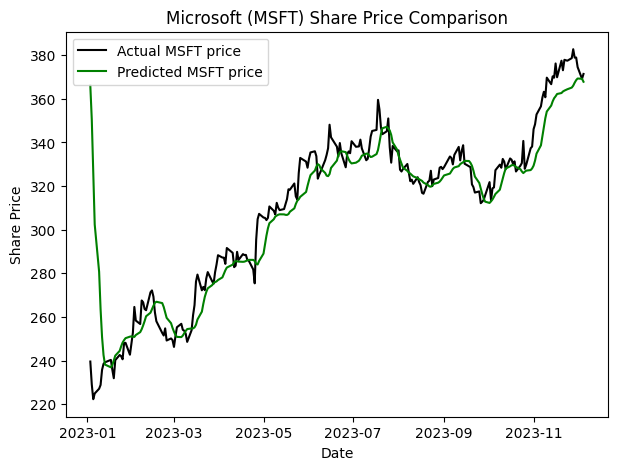

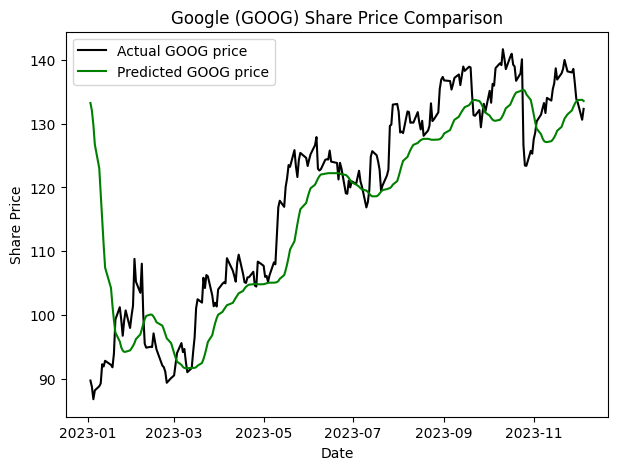

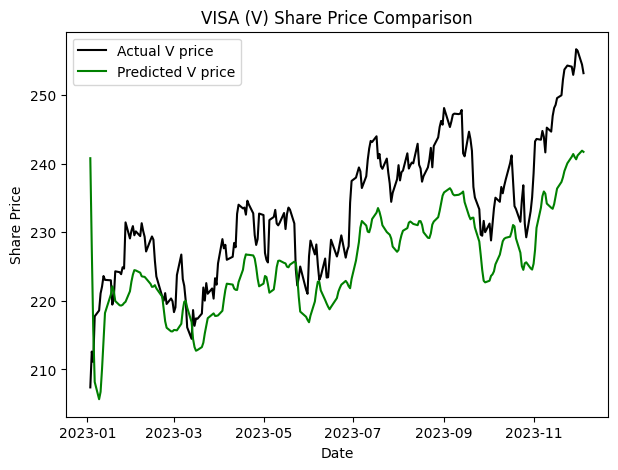

In [18]:
# Plot the actual prices and predicted prices for Microsoft (MSFT)
plt.figure(figsize=(7, 5))
plt.plot(test_data_msft.index, actual_prices_msft, color='black', label="Actual MSFT price")
plt.plot(predicted_dates_msft, predicted_prices_msft, color='green', label="Predicted MSFT price")
plt.title("Microsoft (MSFT) Share Price Comparison")
plt.xlabel("Date")
plt.ylabel("Share Price")
plt.legend()
plt.show()

# Plot the actual prices and predicted prices for Google (GOOG)
plt.figure(figsize=(7, 5))
plt.plot(test_data_goog.index, actual_prices_goog, color='black', label="Actual GOOG price")
plt.plot(predicted_dates_goog, predicted_prices_goog, color='green', label="Predicted GOOG price")
plt.title("Google (GOOG) Share Price Comparison")
plt.xlabel("Date")
plt.ylabel("Share Price")
plt.legend()
plt.show()

# Plot the actual prices and predicted prices for VISA (V)
plt.figure(figsize=(7, 5))
plt.plot(test_data_v.index, actual_prices_v, color='black', label="Actual V price")
plt.plot(predicted_dates_v, predicted_prices_v, color='green', label="Predicted V price")
plt.title("VISA (V) Share Price Comparison")
plt.xlabel("Date")
plt.ylabel("Share Price")
plt.legend()
plt.show()

In [19]:
# Extract the last 'prediction_days' values from the model inputs
real_data_msft = [model_inputs_msft[len(model_inputs_msft) + 1 - prediction_days:len(model_inputs_msft + 1), 0]]
real_data_goog = [model_inputs_goog[len(model_inputs_goog) + 1 - prediction_days:len(model_inputs_goog + 1), 0]]
real_data_v = [model_inputs_v[len(model_inputs_v) + 1 - prediction_days:len(model_inputs_v + 1), 0]]

# Convert the real_data list to a numpy array
real_data_msft = np.array(real_data_msft)
real_data_goog = np.array(real_data_goog)
real_data_v = np.array(real_data_v)

# Reshape real_data to a 3D array with the appropriate dimensions for the LSTM model
real_data_msft = np.reshape(real_data_msft, (real_data_msft.shape[0], real_data_msft.shape[1], 1))
real_data_goog = np.reshape(real_data_goog, (real_data_goog.shape[0], real_data_goog.shape[1], 1))
real_data_v = np.reshape(real_data_v, (real_data_v.shape[0], real_data_v.shape[1], 1))

# Generate a prediction using the LSTM model with the real_data input
prediction_msft = model_msft.predict(real_data_msft)
prediction_goog = model_goog.predict(real_data_goog)
prediction_v = model_v.predict(real_data_v)

# Invert the scaling applied to the prediction to obtain the actual value
prediction_msft = scaler_msft.inverse_transform(prediction_msft)
prediction_goog = scaler_goog.inverse_transform(prediction_goog)
prediction_v = scaler_visa.inverse_transform(prediction_v)

# Print the prediction result to the console
print(f"Prediction MSFT: {prediction_msft[0][0]}")
print(f"Prediction GOOG: {prediction_goog[0][0]}")
print(f"Prediction V: {prediction_v[0][0]}")

1/1 [==============================] - 1s 1s/step
Prediction MSFT: 365.5877380371094
Prediction GOOG: 133.2938995361328
Prediction V: 240.80111694335938


## Performance and Accuracy Metrics

In [20]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

### Mean Absolute Error (MAE):

In [21]:
mae_msft = mean_absolute_error(actual_prices_msft, predicted_prices_msft)
mae_goog = mean_absolute_error(actual_prices_goog, predicted_prices_goog)
mae_v = mean_absolute_error(actual_prices_v, predicted_prices_v)

print ("MAE for MSFT", mae_msft)
print ("MAE for GOOG", mae_goog)
print ("MAE for VISA", mae_v)

MAE for MSFT 8.743354502665639
MAE for GOOG 6.091430172899762
MAE for VISA 7.810918783425258


### Mean Absolute Percentage Error (MAPE):

In [22]:
mape_msft = np.mean(np.abs((actual_prices_msft - predicted_prices_msft) / actual_prices_msft)) * 100
mape_goog = np.mean(np.abs((actual_prices_goog - predicted_prices_goog) / actual_prices_goog)) * 100
mape_v = np.mean(np.abs((actual_prices_v - predicted_prices_v) / actual_prices_v)) * 100

print ("MAPE for MSFT", mape_msft)
print ("MAPE for GOOG", mape_goog)
print ("MAPE for VISA", mape_v)

MAPE for MSFT 13.93684844393074
MAPE for GOOG 15.243807298659847
MAPE for VISA 4.731580173606783


### Mean Squared Error (MSE):

In [23]:
mse_msft = mean_squared_error(actual_prices_msft, predicted_prices_msft)
mse_goog = mean_squared_error(actual_prices_goog, predicted_prices_goog)
mse_v = mean_squared_error(actual_prices_v, predicted_prices_v)

print ("MSE for MSFT", mse_msft)
print ("MSE for GOOG", mse_goog)
print ("MSE for VISA", mse_v)

MSE for MSFT 290.9437230946637
MSE for GOOG 79.91029281429513
MSE for VISA 76.43828607122649


## Simulation

In [24]:
# Calculate price changes
price_changes_msft = np.diff(predicted_prices_msft.flatten())
price_changes_goog = np.diff(predicted_prices_goog.flatten())
price_changes_v = np.diff(predicted_prices_v.flatten())

# Threshold for considering a change as positive or negative
threshold = 0.0

# Generate Direction_prediction based on price changes
direction_prediction_msft = np.where(price_changes_msft > threshold, 1.0, np.where(price_changes_msft < -threshold, -1.0, 0.0))
direction_prediction_goog = np.where(price_changes_goog > threshold, 1.0, np.where(price_changes_goog < -threshold, -1.0, 0.0))
direction_prediction_v = np.where(price_changes_v > threshold, 1.0, np.where(price_changes_v < -threshold, -1.0, 0.0))


In [25]:
# Include Direction_prediction in the DataFrame
test_data_msft.loc[:, 'Direction_prediction'] = np.concatenate([[0], direction_prediction_msft])
test_data_goog.loc[:, 'Direction_prediction'] = np.concatenate([[0], direction_prediction_goog])
test_data_v.loc[:, 'Direction_prediction'] = np.concatenate([[0], direction_prediction_v])

C:\Users\karla\AppData\Local\Temp\ipykernel_22680\887526038.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_msft.loc[:, 'Direction_prediction'] = np.concatenate([[0], direction_prediction_msft])
C:\Users\karla\AppData\Local\Temp\ipykernel_22680\887526038.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_goog.loc[:, 'Direction_prediction'] = np.concatenate([[0], direction_prediction_goog])
C:\Users\karla\AppData\Local\Temp\ipykernel_22680\887526038.py:4: SettingWithCopyWarning: 
A v

In [26]:
# Create the folder if it doesn't exist
folder_name = 'csvDataFrames'
os.makedirs(folder_name, exist_ok=True)

# Save DataFrames to CSV files in the specified folder
test_data_msft.to_csv(os.path.join(folder_name, 'test_data_msft.csv'), index=True)
test_data_goog.to_csv(os.path.join(folder_name, 'test_data_goog.csv'), index=True)
test_data_v.to_csv(os.path.join(folder_name, 'test_data_v.csv'), index=True)


In [31]:
# Import the simulate_trading function from simulation.py
from simulation import simulate_trading
from pathlib import Path

# Read in multiple files saved with the previous section
p = Path('csvDataFrames')
files = p.glob('test_data_*.csv')

# Input number of days to simulate
days_to_simulate = 90 # Replace with days to simulate

# Initialize variables for global sum
global_initial_money = 10000 # Replace with your initial investment amount
global_final_value = 0

# Simulate trading for each stock
for file in files:
    print(f"Processing file: {file}")
    stock_final_value = simulate_trading(file, global_initial_money, days_to_simulate)
    global_final_value += stock_final_value
    print(f"Final value after {days_to_simulate} days: ${stock_final_value:.2f}")

# Print the global sum
print(f"\nInitial investment: ${global_initial_money:.2f}")
print(f"Global final value for all stocks: ${global_final_value:.2f}")

Processing file: csvDataFrames\test_data_goog.csv
Final value after 90 days: $12184.31
Processing file: csvDataFrames\test_data_msft.csv
Final value after 90 days: $11789.54
Processing file: csvDataFrames\test_data_v.csv
Final value after 90 days: $9657.76

Initial investment: $10000.00
Global final value for all stocks: $33631.61
